In [21]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
import datetime
import warnings

# Suppress PerformanceWarning
warnings.filterwarnings("ignore")

## Load data

Prior to loading the data, we identify and categorize columns with string data types in the dataset. Additionally, it selects columns from the 'V' category, focusing on those that exhibit meaningful relationships with the target variable as revealed through correlation-based exploratory data analysis (EDA). By doing so, the code aims to streamline the dataset to include only the most relevant 'V' columns, optimizing computational efficiency and model performance during subsequent analysis and modeling phases.

In [22]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v = [x for x in range(338)]

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [23]:
%%time
# LOAD TRAIN
# X_train = pd.read_csv('./train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
# train_id = pd.read_csv('./train_identity.csv',index_col='TransactionID', dtype=dtypes)
# X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
X_train = pd.read_csv('./train_dataset.csv',index_col='TransactionID', dtype=dtypes)
#X_train = X_train[[x for x in X_train.columns if x in cols+['isFraud']]]
train_id = pd.read_csv('./train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

# LOAD TEST
# X_test = pd.read_csv('./test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
# test_id = pd.read_csv('./test_identity.csv',index_col='TransactionID', dtype=dtypes)
# fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
# test_id.rename(columns=fix, inplace=True)
# X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

X_test = pd.read_csv('./test_dataset.csv',index_col='TransactionID', dtype=dtypes)
#X_test = X_test[[x for x in X_test.columns if x in cols+['isFraud']]]
test_id = pd.read_csv('./test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# del X_train['isFraud']; x = gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (578081, 157) test shape (173242, 157)
CPU times: user 8.33 s, sys: 1.12 s, total: 9.45 s
Wall time: 14.7 s


## Normalizing and converting D columns

After looking at the dataset, we realise that the 'D Columns' represent time intervals relative to a specific past reference point. Our objective is to remove time dependence and convert these 'D Columns' into values that correspond to moments in the past rather than future time intervals. This adjustment ensures that the 'D Columns' no longer exhibit an increasing trend over time because we have normalized it against the effects of time. We achieve this transformation using the formula `D15n = Transaction_Day - D15`, where 'Transaction_Day' is calculated as 'TransactionDT' divided by the number of seconds in a day (24 hours * 60 minutes * 60 seconds). Subsequently, we invert the result by multiplying it by -1.

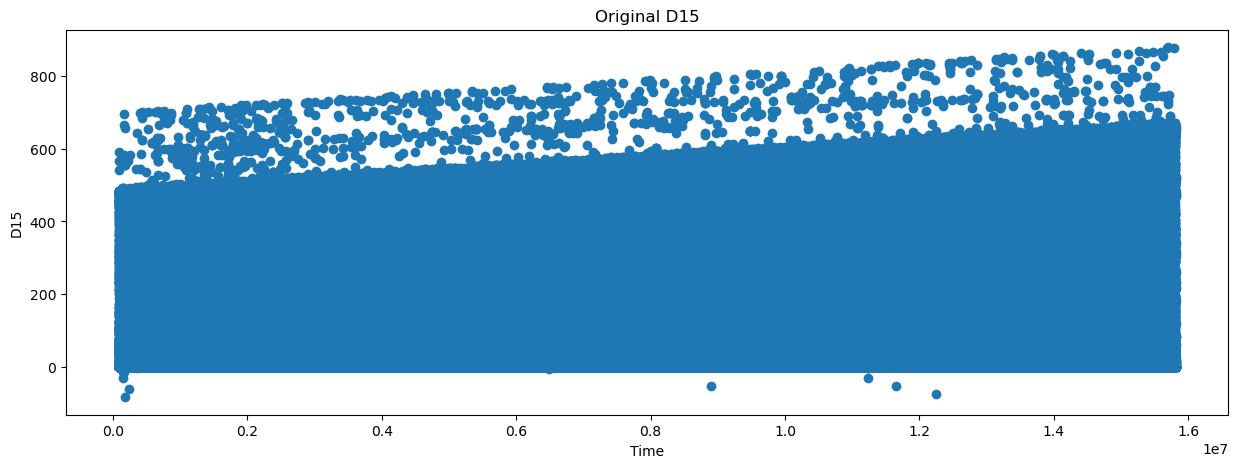

In [24]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

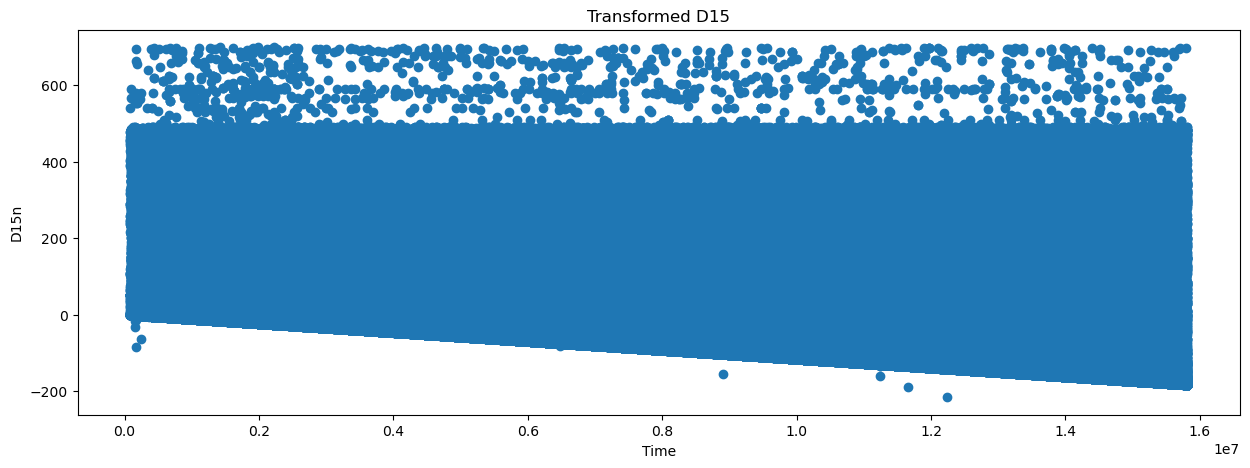

In [25]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if 'D'+str(i) not in X_train.columns: 
        continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
    
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

## Dataset cleaning and preprocessing

Our next step involves the transformation of categorical variables to integers through encoding, the normalization of numeric columns, and addressing any missing data. Given the substantial size of the dataset, we also prioritize memory optimization by ensuring the usage of compatible data types wherever possible. This multi-faceted data preprocessing process aims to enhance the dataset's suitability for analysis and modeling, considering both its size and the type of data it contains.

In [26]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype) == 'category') or (X_train[f].dtype == 'object'): 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000:
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)

CPU times: user 1.03 s, sys: 285 ms, total: 1.31 s
Wall time: 2.05 s


## Encoding functions

To address categorical variables, we must identify and consider all categorical variables that are present in both the test and train sets. This comprehensive approach ensures that we encode all relevant categorical variables consistently across the entire dataset.

1) `encode_FE` performs frequency encoding after in combines the train and test set. This allows us to see whether the column values are rare or common. For example, we can use this to check which credit cards are used infrequently.

2) `encode_LE` performs label encoding on the categorical features and converts them into integers. We factorize to reduce memory and turn NAN into -1.

3) `encode_AG` creates aggregated features such as the aggregated mean and std dev. This allows for the model to tell if a row has abnormal values compared to the mean value.

4) `encode_CB` combines two columns together into one column.

5) `encode_AG2` creates more aggregated features where it counts how many unique values of one feature within a group.

In [27]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    df1 = df1.copy()
    df2 = df2.copy()
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
    train_df = train_df.copy()
    test_df = test_df.copy()

# Feature engineering

In this procedure, we brainstorm potential methods to create new features. Subsequently, we assess each newly generated feature's impact on the Area Under the Curve (AUC) metric. If the addition of a feature leads to an increase in AUC, we retain that feature; otherwise, we eliminate it from consideration. This iterative process helps us identify and incorporate features that enhance model performance while disregarding those that do not contribute positively. The below features are the features that we have thought of that increases the AUC score.

In [28]:
%%time

# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D10','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D10_card1_mean' , 'D10_card1_std' , 'D10_card1_addr1_mean' , 'D10_card1_addr1_std' , 'D10_card1_addr1_P_emaildomain_mean' , 'D10_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 3.87 s, sys: 1.24 s, total: 5.11 s
Wall time: 7.93 s


# Feature selection

Above, we added 28 additional features, bringing the total number of columns to 242, including the index. With this substantial number of features, our goal is to identify the pertinent ones that significantly impact our model's performance. Our chosen evaluation metric is AUC. Therefore, we need to systematically evaluate each feature to ensure that it contributes positively to the model.

We will be using data from the first 30 days as train data to train the model, and use data from the last 30 days as test data to test the model. Specifically, we want to confirm that each feature yields an AUC score >0.5 to be considered valuable, if not the feature is not useful as it is worse than random guessing which yields an AUC score of 0.5. Features failing to meet this criterion are considered non-contributory and will be excluded from further consideration.

In [29]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [30]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier()
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features:   0%|          | 0/185 [00:00<?, ?it/s]

Processing Features: 100%|██████████| 185/185 [06:00<00:00,  1.95s/it]

CPU times: user 6min 23s, sys: 2min 5s, total: 8min 29s
Wall time: 6min


In [31]:
print('Following',len(X_train.columns) - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 42 features removed:
{'V297', 'V1', 'id_32', 'id_23', 'V9', 'addr2', 'V104', 'id_20', 'id_26', 'id_06', 'V7', 'M2', 'V107', 'id_08', 'card4', 'id_21', 'V305', 'id_34', 'id_05', 'id_07', 'V310', 'id_03', 'id_38', 'id_14', 'id_01', 'id_09', 'id_22', 'id_04', 'id_11', 'V286', 'M3', 'id_13', 'id_18', 'M1', 'id_02', 'V289', 'TransactionDT', 'id_24', 'id_25', 'id_17', 'id_19', 'id_10'}
######################################################################
Following 143 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'dist1' 'P_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D10' 'D11'
 'D15' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V5' 'V8' 'V11' 'V13' 'V14' 'V20'
 'V24' 'V26' 'V28' 'V30' 'V34' 'V36' 'V38' 'V41' 'V45' 'V47' 'V49' 'V52'
 'V54' 'V55' 'V56' 'V62' 'V65' 'V67' 'V68' 'V70' 'V74' 'V76' 'V78' 'V83'
 'V87' 'V88' 'V89' 'V91' 'V94' 'V98' 'V100' 'V109' 'V113' 'V114' 'V116

## Local validation 

We conduct a train-test split, where our model is trained on the first 75% of the dataset and assessed on the remaining 25%. In our local validation, the model achieved an AUC of 0.9304.

In [32]:
# train split local validation
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# MODEL SELECTION RUN

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score

In [21]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, roc_auc_score, recall_score

# Decision Tree
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train.loc[idxT, selected_features], y_train[idxT])
dt_preds_proba = clf_dt.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
dt_preds = (dt_preds_proba > 0.5).astype(int)

# Metrics
dt_auc = roc_auc_score(y_train[idxV], dt_preds_proba)
dt_precision = precision_score(y_train[idxV], dt_preds)
dt_accuracy = accuracy_score(y_train[idxV], dt_preds)
dt_f1 = f1_score(y_train[idxV], dt_preds)
dt_recall = recall_score(y_train[idxV], dt_preds)

# Print the metrics including recall
print(f"Decision Tree Metrics -> AUC: {dt_auc:.4f}, Precision: {dt_precision:.4f}, Accuracy: {dt_accuracy:.4f}, F1-Score: {dt_f1:.4f}, Recall: {dt_recall:.4f}")

Decision Tree Metrics -> AUC: 0.6966, Precision: 0.2545, Accuracy: 0.9362, F1-Score: 0.3222, Recall: 0.4392


In [22]:
# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train.loc[idxT, selected_features], y_train[idxT])
rf_preds_proba = clf_rf.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
rf_preds = (rf_preds_proba > 0.5).astype(int)

# Metrics
rf_auc = roc_auc_score(y_train[idxV], rf_preds_proba)
rf_precision = precision_score(y_train[idxV], rf_preds)
rf_accuracy = accuracy_score(y_train[idxV], rf_preds)
rf_f1 = f1_score(y_train[idxV], rf_preds)
rf_recall = recall_score(y_train[idxV], rf_preds)

# Print the metrics including recall
print(f"Random Forest Metrics -> AUC: {rf_auc:.4f}, Precision: {rf_precision:.4f}, Accuracy: {rf_accuracy:.4f}, F1-Score: {rf_f1:.4f}, Recall: {rf_recall:.4f}")


Random Forest Metrics -> AUC: 0.9125, Precision: 0.8575, Accuracy: 0.9751, F1-Score: 0.4807, Recall: 0.3339


In [24]:
# XGBoost
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_xgb.fit(X_train.loc[idxT, selected_features], y_train[idxT])
xgb_preds_proba = clf_xgb.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
xgb_preds = (xgb_preds_proba > 0.5).astype(int)

# Metrics
xgb_auc = roc_auc_score(y_train[idxV], xgb_preds_proba)
xgb_precision = precision_score(y_train[idxV], xgb_preds)
xgb_accuracy = accuracy_score(y_train[idxV], xgb_preds)
xgb_f1 = f1_score(y_train[idxV], xgb_preds)
xgb_recall = recall_score(y_train[idxV], xgb_preds)

# Print the metrics including recall
print(f"XGBoost Metrics -> AUC: {xgb_auc:.4f}, Precision: {xgb_precision:.4f}, Accuracy: {xgb_accuracy:.4f}, F1-Score: {xgb_f1:.4f}, Recall: {xgb_recall:.4f}")

XGBoost Metrics -> AUC: 0.9133, Precision: 0.7832, Accuracy: 0.9748, F1-Score: 0.5049, Recall: 0.3725


In [23]:
# CatBoost
clf_cat = CatBoostClassifier(verbose=0, random_state=42)
clf_cat.fit(X_train.loc[idxT, selected_features], y_train[idxT])
cat_preds_proba = clf_cat.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
cat_preds = (cat_preds_proba > 0.5).astype(int)

# Metrics
cat_auc = roc_auc_score(y_train[idxV], cat_preds_proba)
cat_precision = precision_score(y_train[idxV], cat_preds)
cat_accuracy = accuracy_score(y_train[idxV], cat_preds)
cat_f1 = f1_score(y_train[idxV], cat_preds)
cat_recall = recall_score(y_train[idxV], cat_preds)

# Print the metrics including recall
print(f"CatBoost Metrics -> AUC: {cat_auc:.4f}, Precision: {cat_precision:.4f}, Accuracy: {cat_accuracy:.4f}, F1-Score: {cat_f1:.4f}, Recall: {cat_recall:.4f}")

CatBoost Metrics -> AUC: 0.9114, Precision: 0.8118, Accuracy: 0.9751, F1-Score: 0.5039, Recall: 0.3653


In [26]:
# LightGBM
clf_lgbm = lgb.LGBMClassifier(random_state=42)
clf_lgbm.fit(X_train.loc[idxT, selected_features], y_train[idxT])
lgbm_preds_proba = clf_lgbm.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
lgbm_preds = (lgbm_preds_proba > 0.5).astype(int)

# Metrics
lgbm_auc = roc_auc_score(y_train[idxV], lgbm_preds_proba)
lgbm_precision = precision_score(y_train[idxV], lgbm_preds)
lgbm_accuracy = accuracy_score(y_train[idxV], lgbm_preds)
lgbm_f1 = f1_score(y_train[idxV], lgbm_preds)
lgbm_recall = recall_score(y_train[idxV], lgbm_preds)

# Print the metrics including recall
print(f"LightGBM Metrics -> AUC: {lgbm_auc:.4f}, Precision: {lgbm_precision:.4f}, Accuracy: {lgbm_accuracy:.4f}, F1-Score: {lgbm_f1:.4f}, Recall: {lgbm_recall:.4f}")

[LightGBM] [Info] Number of positive: 15563, number of negative: 427342
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23675
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035138 -> initscore=-3.312688
[LightGBM] [Info] Start training from score -3.312688
LightGBM Metrics -> AUC: 0.9111, Precision: 0.7468, Accuracy: 0.9733, F1-Score: 0.4706, Recall: 0.3435


In [25]:
# Logistic Regression
clf_lr = LogisticRegression(random_state=42)  # Increased max_iter for convergence
clf_lr.fit(X_train.loc[idxT, selected_features], y_train[idxT])
lr_preds_proba = clf_lr.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
lr_preds = (lr_preds_proba > 0.5).astype(int)

# Metrics
lr_auc = roc_auc_score(y_train[idxV], lr_preds_proba)
lr_precision = precision_score(y_train[idxV], lr_preds)
lr_accuracy = accuracy_score(y_train[idxV], lr_preds)
lr_f1 = f1_score(y_train[idxV], lr_preds)
lr_recall = recall_score(y_train[idxV], lr_preds)

# Print the metrics including recall
print(f"Logistic Regression Metrics -> AUC: {lr_auc:.4f}, Precision: {lr_precision:.4f}, Accuracy: {lr_accuracy:.4f}, F1-Score: {lr_f1:.4f}, Recall: {lr_recall:.4f}")


Logistic Regression Metrics -> AUC: 0.7299, Precision: 0.0000, Accuracy: 0.9652, F1-Score: 0.0000, Recall: 0.0000
